<a href="https://colab.research.google.com/github/alysonfumagalli/projeto-spoesta/blob/main/codigo/sim-srag-inferencia/srag-sim-inferencial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparação do ambiente

In [ ]:
#@title **Importar bibliotecas** { vertical-output: true, form-width: "60%" }

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from IPython.display import display, HTML
from scipy.stats import chisquare
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

## Importar Datasets do SIM e SRAG

In [ ]:
df_srag_url = "https://drive.usercontent.google.com/uc?id=1E1N10m0YPm0g2PvAnSO5YYc1sFfqrzRi&export=download"
df_sim_url = "https://drive.usercontent.google.com/uc?id=1P1-TtXlJMgyvVPStpAWHUES55ZqSMoq2&export=download"

df_srag = pd.read_csv(df_srag_url, sep=',', encoding='utf-8')
df_sim = pd.read_csv(df_sim_url, sep=',', encoding='utf-8')

/tmp/ipython-input-18-1579435573.py:4: DtypeWarning: Columns (59,61,62,63,91,105,114,116,117,118,122,143) have mixed types. Specify dtype option on import or set low_memory=False.
  df_srag = pd.read_csv(df_srag_url, sep=',', encoding='utf-8')
/tmp/ipython-input-18-1579435573.py:5: DtypeWarning: Columns (66) have mixed types. Specify dtype option on import or set low_memory=False.
  df_sim = pd.read_csv(df_sim_url, sep=',', encoding='utf-8')


## Reduzir e exportar os dados para CSV (Opcional)

In [ ]:
# df_sim = df_sim.sample(n=100000, random_state=42)
# df_sim.to_csv('/content/drive/MyDrive/COLAB-DATASETS/SPOESTAT/SIM-2021-RESIZED.csv', index=False)

# Análise e Investigação dos dados

## Análise 1: Comparação entre proporções de COVID-19 entre SIM e SRAG

### Tópico da estatística inferencial

O tópico abordado na estatística inferencial é o teste de hipótese para a diferença entre duas proporções populacionais

### Objetivo

Essa análise tem como objetivo verificar se a proporção de casos evoluídos para óbito por COVID-19 (SRAG) é compatível com a proporção de óbitos (SIM) por COVID-19, realizando agregação por faixa etária.

### Perguntas feitas a partir dessa análise

- Existe diferença estatisticamente significativa entre a proporção de casos de COVID-19 no SRAG e a proporção de óbitos no SIM?
- Quais faixa etárias apresentam maiores diferenças entre proporções?
- A proporção de COVID-19 por faixa etária se mantém semelhante em ambos os sistemas?
- Os dados do SRAG são suficientes para inferir sobre os óbitos por COVID-19 ou há subnotificação ou atraso nos registros do SIM?

### Etapas

#### 1º Etapa: Investigação das colunas a serem utilizadas

In [ ]:
# SRAG - Descrição dos valores de CLASSI_FIN
## 1-SRAG por influenza
## 2-SRAG por outro vírus respiratório
## 3-SRAG por outro agente etiológico, qual:
## 4-SRAG não especificado
## 5-SRAG por covid-19
print("-------------- SRAG --------------")
print("Possíveis valores para a coluna CLASSI_FIN:", df_srag['CLASSI_FIN'].unique())
print("Quantidade de valores nulos na coluna CLASSI_FIN:", df_srag['CLASSI_FIN'].isna().sum())

# SID - Descrição dos valores de CLASSI_FIN
## Possíveis causas da morte (SID)
print("\n\n-------------- SIM --------------")
print("Possíveis valores para a coluna LINHAA:", df_sim['LINHAA'].unique())
print("Quantidade de valores nulos na coluna LINHAA:", df_sim['LINHAA'].isna().sum())

print("\n\n-------------- Geral --------------")
print("Quantidade total de dados antes da limpeza no SRAG:", len(df_srag))
print("Quantidade total de dados antes da limpeza no SIM:", len(df_sim))

-------------- SRAG --------------
Possíveis valores para a coluna CLASSI_FIN: [ 5.  4. nan  2.  1.  3.]
Quantidade de valores nulos na coluna CLASSI_FIN: 4649


-------------- SIM --------------
Possíveis valores para a coluna LINHAA: ['*R98X' '*A419' '*R961' ... '*X740' '*Q743' '*I871']
Quantidade de valores nulos na coluna LINHAA: 4159


-------------- Geral --------------
Quantidade total de dados antes da limpeza no SRAG: 100000
Quantidade total de dados antes da limpeza no SIM: 100000


#### 2º Etapa: Carregamento e limpeza dos dados

In [ ]:
# SRAG: Limpeza
classi_fin_valores_validos = [1, 2, 3, 4, 5]
df_srag_classi_fin_not_null = df_srag[df_srag['CLASSI_FIN'].notnull()]
df_srag_classi_fin_validos = df_srag_classi_fin_not_null[df_srag_classi_fin_not_null['CLASSI_FIN'].isin(classi_fin_valores_validos)]

# SRAG: Filtro
filtro_srag_classi_fin_covid = (df_srag_classi_fin_validos['CLASSI_FIN'] == 5) & (df_srag_classi_fin_validos['EVOLUCAO'] == 2)
df_srag_classi_fin_validos = df_srag_classi_fin_validos[filtro_srag_classi_fin_covid]

# SIM: Limpeza
sim_colunas_cid = ['LINHAA', 'LINHAB', 'LINHAC', 'LINHAD', 'LINHAII']
for col in sim_colunas_cid:
    df_sim[col] = df_sim[col].astype(str).str.upper().str.strip()

# SIM: Filtro
## CID B34.2: Casos leves ou suspeitos antes da confirmação por PCR.
## CID U07.1: COVID-19 confirmado laboratorialmente.
## CID U07.2: COVID-19 clinicamente ou epidemiologicamente diagnosticado, mas não confirmado por teste.

cid_covid_validos = ['B342', 'U071', 'U072']
filtro_sim_cid_covid = df_sim[sim_colunas_cid].apply(
    lambda row: any(any(cid in cell for cid in cid_covid_validos) for cell in row),
    axis=1
)
df_sim_cid_validos = df_sim[filtro_sim_cid_covid]

print("Quantidade total de dados após a limpeza no SRAG:", len(df_srag_classi_fin_validos))
print("Quantidade total de dados após a limpeza no SIM:", len(df_sim_cid_validos))

Quantidade total de dados após a limpeza no SRAG: 21707
Quantidade total de dados após a limpeza no SIM: 24138


#### 3º Etapa: Agrupamento dos dados

/tmp/ipython-input-22-609846412.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_srag_faixa_etaria_agrupado = df_srag_classi_fin_validos.groupby('FAIXAETARIA').size().reset_index(name='QUANTIDADE_CASOS_COVID_SRAG')
/tmp/ipython-input-22-609846412.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_sim_faixa_etaria_agrupada = df_sim_cid_validos.groupby('FAIXAETARIA').size().reset_index(name='QUANTIDADE_CASOS_COVID_SIM')
/tmp/ipython-input-22-609846412.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to re

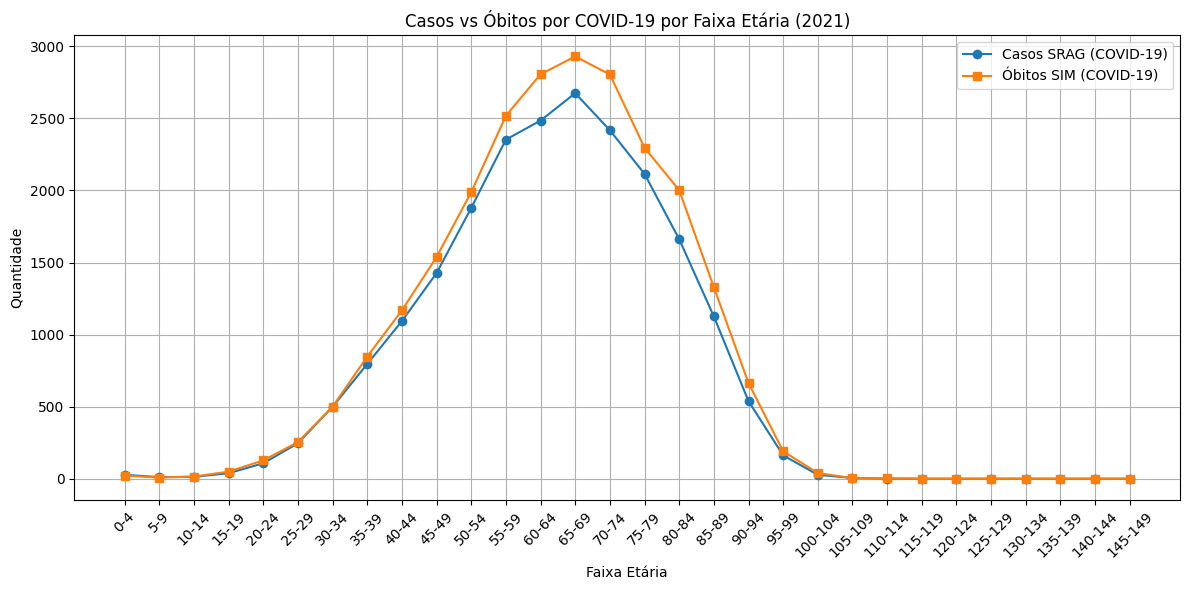

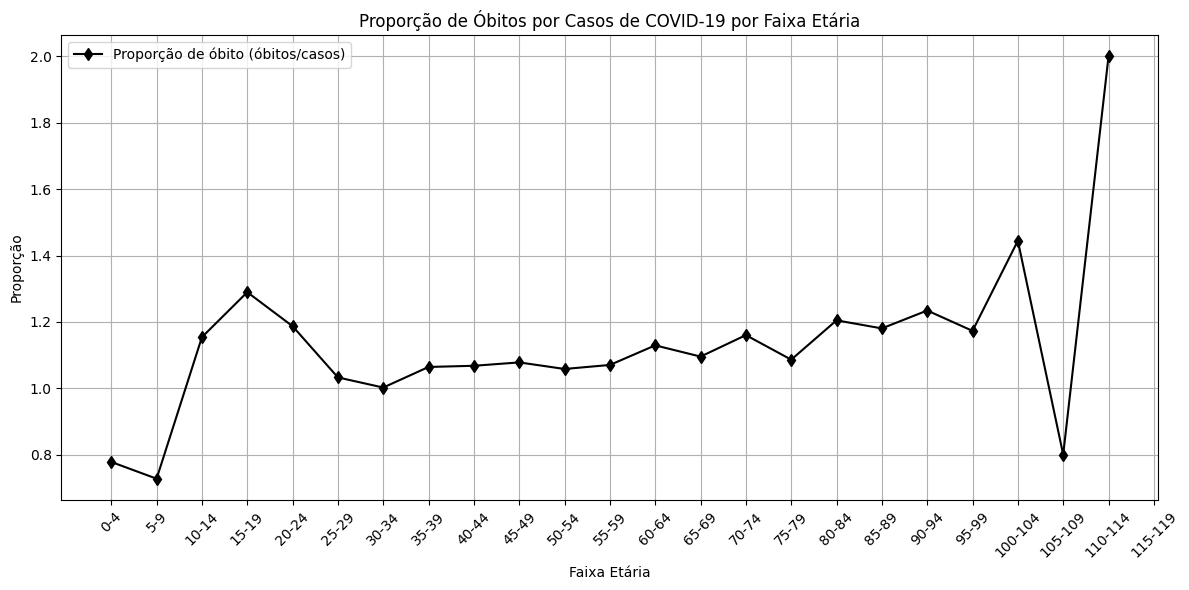

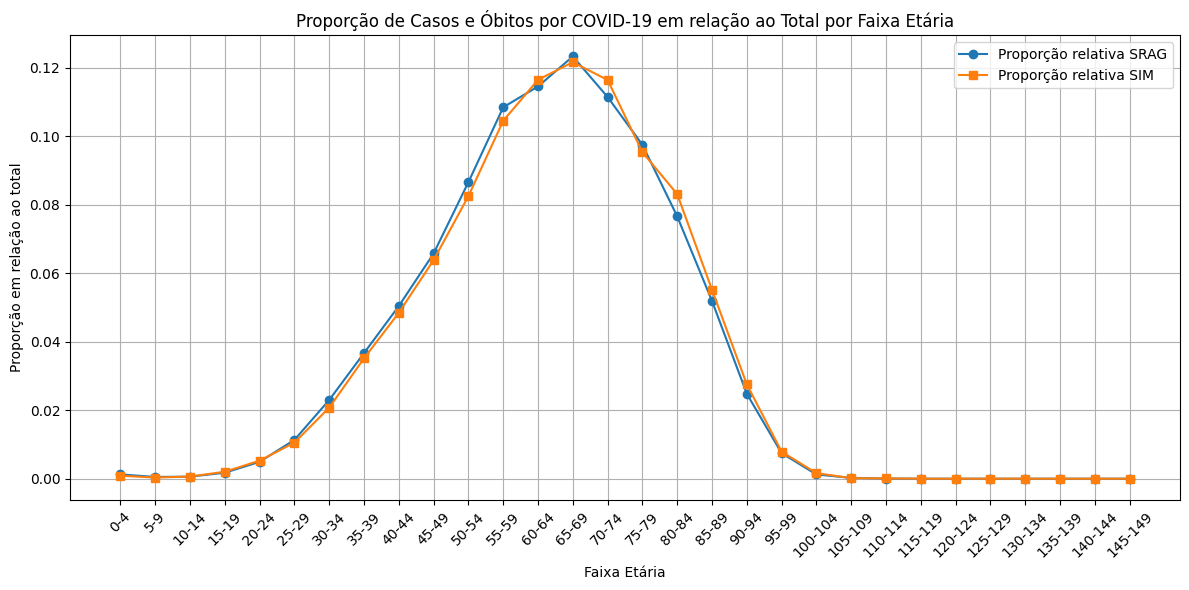

In [ ]:
def converter_idade_sim(codigo_idade):
    if pd.isna(codigo_idade) or len(str(codigo_idade)) < 3:
        return np.nan
    codigo_idade = str(codigo_idade).zfill(3)
    unidade = int(codigo_idade[0])
    valor = int(codigo_idade[1:])
    if unidade == 1: return 0
    if unidade == 2: return 0
    if unidade == 3: return 0
    if unidade == 4: return valor
    if unidade == 5: return 100 + valor
    return np.nan

bins_idade = list(range(0, 155, 5))
labels_idade = [f'{i}-{i+4}' for i in range(0, 150, 5)]

# SRAG e SIM: Tratamento dos dados
df_srag_classi_fin_validos['FAIXAETARIA'] = pd.cut(df_srag_classi_fin_validos['NU_IDADE_N'], bins=bins_idade, labels=labels_idade, right=True)

df_sim_cid_validos['IDADE_ANOS'] = df_sim_cid_validos['IDADE'].apply(converter_idade_sim)
df_sim_cid_validos = df_sim_cid_validos[df_sim_cid_validos['IDADE_ANOS'].notna()]
df_sim_cid_validos['IDADE_ANOS'] = df_sim_cid_validos['IDADE_ANOS'].astype(int)
df_sim_cid_validos['FAIXAETARIA'] = pd.cut(df_sim_cid_validos['IDADE_ANOS'], bins=bins_idade, labels=labels_idade, right=True)

# SRAG e SIM: Agrupamento dos dados por idade
df_srag_faixa_etaria_agrupado = df_srag_classi_fin_validos.groupby('FAIXAETARIA').size().reset_index(name='QUANTIDADE_CASOS_COVID_SRAG')
df_sim_faixa_etaria_agrupada = df_sim_cid_validos.groupby('FAIXAETARIA').size().reset_index(name='QUANTIDADE_CASOS_COVID_SIM')


# SRAG e SIM: Merge e tratamento
df_comparativo_nacional = pd.merge(
    df_srag_faixa_etaria_agrupado,
    df_sim_faixa_etaria_agrupada,
    on='FAIXAETARIA',
    how='inner'
)

# Calcular razão óbitos / casos (evita divisão por zero)
df_comparativo_nacional['PROPORCAO_OBITO'] = df_comparativo_nacional['QUANTIDADE_CASOS_COVID_SIM'] / df_comparativo_nacional['QUANTIDADE_CASOS_COVID_SRAG'].replace(0, np.nan)

# Somar todos os estados para comparar por faixa etária
df_faixa = df_comparativo_nacional.groupby('FAIXAETARIA')[['QUANTIDADE_CASOS_COVID_SRAG', 'QUANTIDADE_CASOS_COVID_SIM']].sum().reset_index()


# Gráfico
plt.figure(figsize=(12,6))
plt.plot(df_faixa['FAIXAETARIA'], df_faixa['QUANTIDADE_CASOS_COVID_SRAG'], marker='o', label='Casos SRAG (COVID-19)')
plt.plot(df_faixa['FAIXAETARIA'], df_faixa['QUANTIDADE_CASOS_COVID_SIM'], marker='s', label='Óbitos SIM (COVID-19)')
plt.xlabel('Faixa Etária')
plt.ylabel('Quantidade')
plt.title('Casos vs Óbitos por COVID-19 por Faixa Etária (2021)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Gráfico de proporção de óbitos/casos
plt.figure(figsize=(12,6))
plt.plot(df_faixa['FAIXAETARIA'], df_faixa['QUANTIDADE_CASOS_COVID_SIM'] / df_faixa['QUANTIDADE_CASOS_COVID_SRAG'], marker='d', color='black', label='Proporção de óbito (óbitos/casos)')
plt.xlabel('Faixa Etária')
plt.ylabel('Proporção')
plt.title('Proporção de Óbitos por Casos de COVID-19 por Faixa Etária')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Calcular proporção de cada faixa etária em relação ao total de cada base
total_srag = df_faixa['QUANTIDADE_CASOS_COVID_SRAG'].sum()
total_sim = df_faixa['QUANTIDADE_CASOS_COVID_SIM'].sum()

df_faixa['PROPORCAO_SRAG'] = df_faixa['QUANTIDADE_CASOS_COVID_SRAG'] / total_srag
df_faixa['PROPORCAO_SIM'] = df_faixa['QUANTIDADE_CASOS_COVID_SIM'] / total_sim

plt.figure(figsize=(12,6))
plt.plot(df_faixa['FAIXAETARIA'], df_faixa['PROPORCAO_SRAG'], marker='o', label='Proporção relativa SRAG')
plt.plot(df_faixa['FAIXAETARIA'], df_faixa['PROPORCAO_SIM'], marker='s', label='Proporção relativa SIM')
plt.xlabel('Faixa Etária')
plt.ylabel('Proporção em relação ao total')
plt.title('Proporção de Casos e Óbitos por COVID-19 em relação ao Total por Faixa Etária')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#### 4º Proporções, testes Z para proporções em duas amostras e teste de hipóteses.

- Com base nos dados agrupados de óbitos por COVID-19 por faixa etária nos sistemas SRAG e SIM, observamos que ambos apresentam padrões semelhantes de distribuição entre as faixas etárias, com pequenas variações. Para sustentar essa afirmação, aplicamos o teste de hipótese para a comparação de proporções em cada faixa etária (Teste Z para proporção em diferentes amostras), utilizando a proporção de óbitos em cada sistema (SIM e SRAG). Dessa forma, foi possível verificar, faixa por faixa, se a proporção de registros se mantém
- Diante disso, temos que:
  - **Hipóteses do teste**
    - Hipótese nula (H₀): A proporção de óbitos por COVID-19 na faixa etária I é igual entre os sistemas SRAG e SIM.
      - H₀: p₁ = p₂
    - Hipótese alternativa (H₁): A proporção de óbitos por COVID-19 difere entre os sistemas SRAG e SIM na faixa etária I.
      - H₁: p₁ ≠ p₂
  - **Fórmulas utilizadas:**
    - Proporções individuais
      - p₁ = óbitos_SIMᵢ / total_SIM
      - p₂ = óbitos_SRAGᵢ / total_SRAG
    - Proporção combinada
      - p = (x₁ + x₂) / (n₁ + n₂)
    - Erro padrão
      - SE = √[p(1-p)(1/n₁ + 1/n₂)]
    - Estatística Z
      - z = (p₁ - p₂) / SE
    - Intervalo de Confiança: 95%






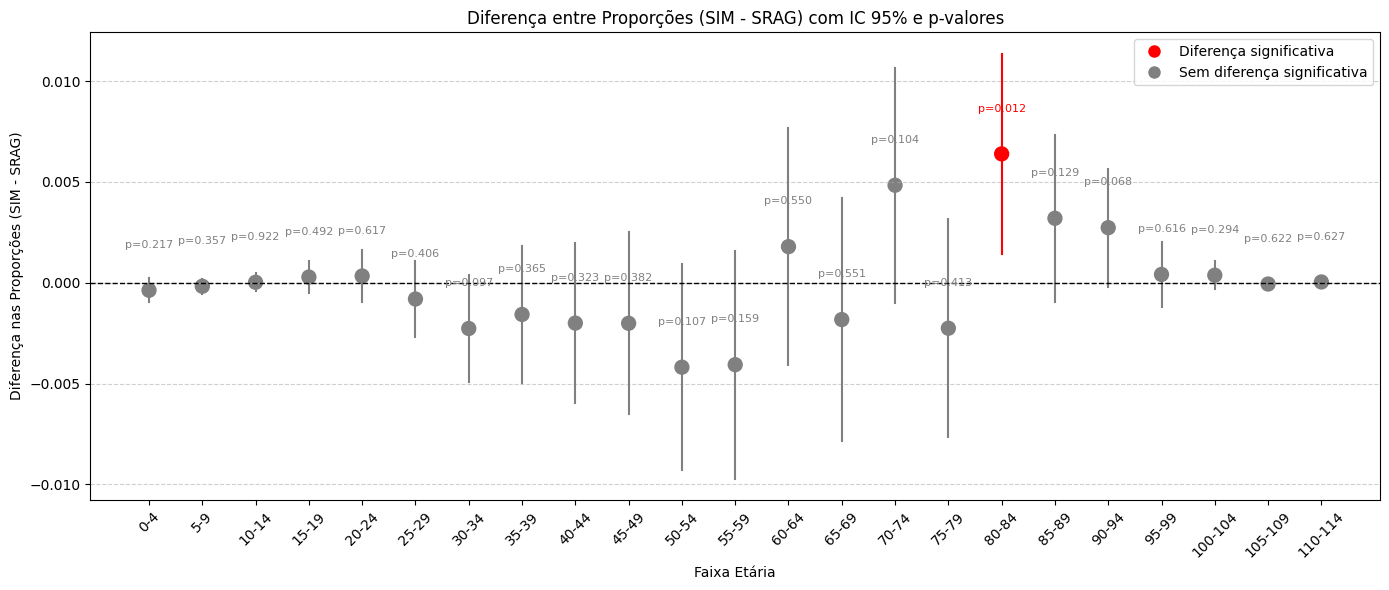

In [ ]:
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np

# Totais das bases
total_sim = df_sim_cid_validos.shape[0]
total_srag = df_srag_classi_fin_validos.shape[0]

resultados_z_corrigido = []

for faixa in df_faixa['FAIXAETARIA']:
    try:
        x_sim = df_sim_faixa_etaria_agrupada.loc[df_sim_faixa_etaria_agrupada['FAIXAETARIA'] == faixa, 'QUANTIDADE_CASOS_COVID_SIM'].values[0]
        x_srag = df_srag_faixa_etaria_agrupado.loc[df_srag_faixa_etaria_agrupado['FAIXAETARIA'] == faixa, 'QUANTIDADE_CASOS_COVID_SRAG'].values[0]

        # Proporções em relação ao total
        p1 = x_sim / total_sim
        p2 = x_srag / total_srag

        # Proporção combinada
        p_comb = (x_sim + x_srag) / (total_sim + total_srag)

        # Erro padrão
        se = np.sqrt(p_comb * (1 - p_comb) * (1/total_sim + 1/total_srag))
        if se == 0 or np.isnan(se): continue

        # Estatística Z
        z = (p1 - p2) / se

        # P-valor (bicaudal)
        p_valor = 2 * (1 - norm.cdf(abs(z)))

        # Intervalo de confiança
        ic_inf = (p1 - p2) - 1.96 * se
        ic_sup = (p1 - p2) + 1.96 * se

        resultados_z_corrigido.append({
            'Faixa Etária': faixa,
            'Proporção SIM': round(p1, 6),
            'Proporção SRAG': round(p2, 6),
            'Diferença': round(p1 - p2, 6),
            'Z': round(z, 3),
            'P-valor': round(p_valor, 4),
            'IC 95%': f'({ic_inf:.6f}, {ic_sup:.6f})',
            'Conclusão': 'Sem diferença significativa' if p_valor > 0.05 else 'Diferença significativa'
        })
    except:
        continue

df_resultados_z_corrigido = pd.DataFrame(resultados_z_corrigido)

# Separar valores do intervalo de confiança para plotar
df_resultados_z_corrigido[['IC_inf', 'IC_sup']] = df_resultados_z_corrigido['IC 95%'].str.extract(r'\(([^,]+), ([^)]+)\)').astype(float)
cores = df_resultados_z_corrigido['Conclusão'].map({
    'Diferença significativa': 'red',
    'Sem diferença significativa': 'gray'
})

plt.figure(figsize=(14, 6))

# Plot dos pontos
plt.scatter(
    x=df_resultados_z_corrigido['Faixa Etária'],
    y=df_resultados_z_corrigido['Diferença'],
    color=cores,
    s=100,
    label='Diferença de proporções'
)

# Linhas de intervalo de confiança
for i, row in df_resultados_z_corrigido.iterrows():
    plt.plot([row['Faixa Etária'], row['Faixa Etária']],
             [row['IC_inf'], row['IC_sup']],
             color=cores[i], linewidth=1.5)

    # Valores do p-valor em cada ponto de cada faixa etaria
    plt.text(row['Faixa Etária'], row['Diferença'] + 0.002,
             f"p={row['P-valor']:.3f}",
             ha='center', va='bottom', fontsize=8, color=cores[i])

plt.axhline(0, color='black', linestyle='--', linewidth=1)

plt.title('Diferença entre Proporções (SIM - SRAG) com IC 95% e p-valores')
plt.xlabel('Faixa Etária')
plt.ylabel('Diferença nas Proporções (SIM - SRAG)')
plt.xticks(rotation=45)
plt.grid(True, axis='y', linestyle='--', alpha=0.6)

from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Diferença significativa',
           markerfacecolor='red', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Sem diferença significativa',
           markerfacecolor='gray', markersize=10)
]
plt.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()


Aplicamos o teste de hipótese para verificar se a proporção de óbitos por COVID-19 entre os sistemas SRAG e SIM são semelhantes dentro das mesmas faixas etárias.

Com base no teste Z, para a maioria das faixas etárias o p-valor foi superior a 0,05, indicando ausência de diferença estatisticamente significativa entre os dois sistemas.

Isso reforça a coerência e convergência entre as bases de dados para a vigilância da mortalidade por COVID-19.

### Resposta das perguntas baseado nos resultados

1. Existe diferença estatisticamente significativa entre a proporção de casos de COVID-19 no SRAG e a proporção de óbitos no SIM?
  - Sim, mas apenas em faixas específicas. Grande parte das faixas não apresentou diferença significativa entre a proporção de óbitos (SIM) e casos graves (SRAG). No entanto, uma outra faixa (como 80 e 84 anos) apresentou um p-valor menor que 0.05, uma diferença maior no gráfico e um aumento da proporção de óbitos/casos, indicando diferença significativa.

2. Quais faixas etárias apresentam maiores diferenças entre proporções?
  - A faixa de 80-84 anos foi a única que apresentou uma diferença estatística significativa. As demais faixas mantêm diferenças pequenas ou estatisticamente não signficiativas.

3. A proporção de COVID-19 por faixa etária se mantém semelhante em ambos os sistemas?
  - De modo geral, sim, uma vez que as curvas de distribuição do SRAG e do SIM são bastante semelhantes, conforme o gráfico de proporções relativas, o que reforça a consistência entre os sistemas. Tanto o SIM quanto SRAG seguem um padrão de distribuição etária típico de mortalidade da COVID-19.

4. Os dados do SRAG são suficientes para inferir sobre os óbitos por COVID-19 ou há subnotificação ou atraso nos registros do SIM?
  - Sim, pois existe um forte alinhamento entre os dados do SRAG e do SIM em quase todas as faixas etárias indica que o SRAG pode ser uma boa base de dados para predição de mortalidade por COVID-19, embora sejam notadas pequenas variações ou atrasos em faixas específicas que não devem ser ignoradas.

### Conclusão

- A análise comparativa entre os sistemas SRAG e SIM revelou uma alta correlação entre os padrões etários de casos graves e óbitos por COVID-19 em 2021. Foram aplicados testes de hipótese (teste Z para proporções) para verificar se as proporções por faixa etária diferem estatisticamente entre as bases.
- Os resultados indicam que na maioria das faixas etárias não há diferença significativa, reforçando a consistência entre os dois sistemas de notificação. A exceção foi observada na faixa de 80–84 anos, onde a diferença foi estatisticamente significativa. Ainda assim, essa variação pontual não compromete a tendência geral observada nos dados.
- Além disso, a distribuição proporcional em relação ao total — apresentada em gráfico adicional — mostra que os perfis de mortalidade e gravidade da doença por faixa etária se mantêm bastante similares.
- Concluímos, portanto, que os dados do SRAG são, em geral, representativos e confiáveis para inferir sobre a mortalidade por COVID-19, com ressalvas pontuais que podem refletir variações operacionais, atraso de notificação ou fatores específicos de coleta em algumas faixas etárias.



## Análise 2: comparar a letalidade aparente no SRAG com a taxa de mortalidade no SIM

**Objetivo:** realizar testes de hipótese para comparar a letalidade aparente no SRAG e a taxa de mortalidade no SIM (considerando as amostras extraídas) para o ano de 2021.

**Teste a ser realizado:** teste de proporção usando qui-quadrado.

**Hipóteses definidas:**
* **Hipótese Nula (H₀):** a taxa de mortalidade registrada no SIM é proporcional à letalidade observada no SRAG.
* **Hipótese Alternativa (Ha):** há uma diferença significativa (subnotificação ou excesso em alguns dos *datasets*.

**Considerar:**
* **Nível de significância (α):** 0.05

### Preparação dos dados

In [ ]:
# Filtrando somente as colunas necessárias
sim = df_sim[['CAUSABAS']].copy()
srag = df_srag[['CLASSI_FIN', 'EVOLUCAO']].copy()

# Mapeando as colunas do SRAG
srag['CLASSI_FIN_DESC'] = srag['CLASSI_FIN'].map({
    1: 'Por influenza',
    2: 'Por outro vírus',
    3: 'Por outro agente',
    4: 'Não especificado',
    5: 'Por covid-19'
})

srag['EVOLUCAO_DESC'] = srag['EVOLUCAO'].map({
    1: 'Cura',
    2: 'Óbito',
    3: 'Óbito por outras causas',
    9: 'Ignorado'
})

In [ ]:
# @title { vertical-output: true, form-width: "50%" }

# Visualizando o head do SIM
sim.head()

,CAUSABAS
0,I10
1,B342
2,I500
3,I64
4,B342


In [ ]:
# @title { vertical-output: true, form-width: "50%" }

# Visualizando o head do SRAG
srag.head()

,CLASSI_FIN,EVOLUCAO,CLASSI_FIN_DESC,EVOLUCAO_DESC
0,5.0,NaN,Por covid-19,NaN
1,4.0,2.0,Não especificado,Óbito
2,5.0,9.0,Por covid-19,Ignorado
3,5.0,1.0,Por covid-19,Cura
4,5.0,1.0,Por covid-19,Cura


### Análise

In [ ]:
# DADOS GERAIS

# Tamanho amostral dos datasets
n_srag = len(srag)
n_sim = len(sim)

# Nível de significância (α)
alpha = 0.05

In [ ]:
# PROPORÇÕES DA ANÁLISE

# SIM
# Filtrando óbitos por COVID-19
filtro_sim_covid = sim['CAUSABAS'].astype(str).str.match('B342')

# Calculando proporções de óbito por COVID-19
p_sim_obito_covid = filtro_sim_covid.mean()
p_sim_obito_nao_covid = 1 - p_sim_obito_covid

# Proporções esperadas
expected_proportions = np.array([p_sim_obito_covid.round(2), p_sim_obito_nao_covid.round(2)])
expected = n_srag * expected_proportions   # Utilizou-se como n o tamanho amostral do SRAG
print(expected)

# SRAG
# Filtrando óbitos por COVID-19
filtro_srag_covid = ((srag['CLASSI_FIN_DESC'] == 'Por covid-19') & (srag['EVOLUCAO_DESC'] == 'Óbito'))
srag_covid = srag[filtro_srag_covid]

# Proporções observadas
n_srag_covid = len(srag_covid)
observed = np.array([n_srag_covid, n_sim - n_srag_covid])

# Exibindo resultados
print(f"Proporções esperadas (SIM): {expected_proportions[0]} → {expected_proportions[0]:.2%} (óbitos por COVID-19) e {expected_proportions[1]} → {expected_proportions[1]:.2%} (não óbitos por COVID-19)")
print(f"Proporções observadas (SRAG): {observed[0]} (óbitos por COVID-19) e {observed[1]} (óbitos não COVID-19)")

[23000. 77000.]
Proporções esperadas (SIM): 0.23 → 23.00% (óbitos por COVID-19) e 0.77 → 77.00% (não óbitos por COVID-19)
Proporções observadas (SRAG): 21707 (óbitos por COVID-19) e 78293 (óbitos não COVID-19)


#### Gerando o Gráfico

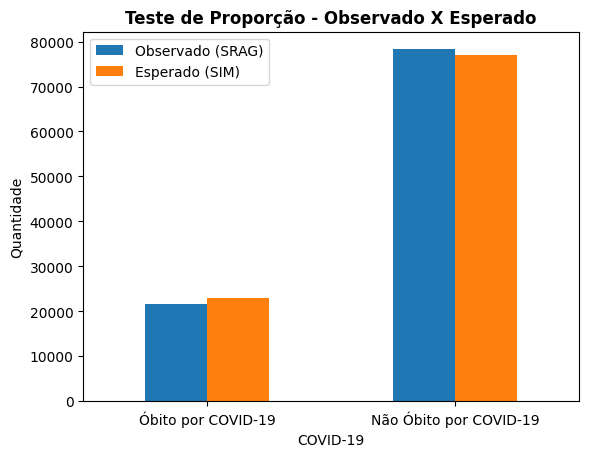

In [ ]:
# Criando novo dataframe
analise = pd.DataFrame({
    "Resposta": ['Óbito por COVID-19', 'Não Óbito por COVID-19'],
    "Observado": observed,
    "Esperado": expected
})

# Gráfico
analise.plot(x="Resposta", kind="bar", stacked=False)
plt.title("Teste de Proporção - Observado X Esperado", weight='bold')
plt.xlabel("COVID-19")
plt.ylabel("Quantidade")
plt.xticks(rotation=0)
plt.legend(["Observado (SRAG)", "Esperado (SIM)"])
plt.show()

#### **Realizando o Teste Qui-Quadrado**

In [ ]:
# Teste de Qui-Quadrado
chi2_stat, p_value = chisquare(f_obs=observed, f_exp=expected)

# Resultados
# Mede a diferença entre observado e esperado
print(f"Diferença entre os valores observados e esperados: {chi2_stat:.4f}")

# Representa a probabilidade de observar uma diferença ou algo mais extremo, assumindo que H₀ é verdadeira
print(f"Valor do p-value: {p_value:.9f} ({p_value:.7%})")

Diferença entre os valores observados e esperados: 94.4014
Valor do p-value: 0.000000000 (0.0000000%)


## Análise 3: Comparação da Idade Média ao Óbito entre Regiões com Alta e Baixa Incidência de SRAG


Mediana de taxa de internações SRAG por UF: 40.311344868320944
Número de UFs no grupo de alta incidência: 13
Número de UFs no grupo de baixa incidência: 14

Teste Shapiro-Wilk para Idade Média ao Óbito (Alta Incidência SRAG): Estatística=0.9230, p-valor=0.2752
Teste Shapiro-Wilk para Idade Média ao Óbito (Baixa Incidência SRAG): Estatística=0.9219, p-valor=0.2341

Teste t independente comparando a Idade Média ao Óbito entre grupos de Alta vs. Baixa Incidência SRAG:
Estatística t: 2.6784
P-valor: 0.0129
Resultado: O p-valor (0.0129) é menor que o nível de significância (0.05).
Rejeitamos a hipótese nula. Há uma diferença estatisticamente significativa na idade média ao óbito entre regiões com alta e baixa incidência de internações SRAG.

Estatísticas Descritivas da Idade Média ao Óbito por Grupo:
Grupo Alta Incidência SRAG:
count    13.000000
mean     65.147739
std       2.240353
min      61.769870
25%      63.020190
50%      65.161137
75%      66.893833
max      68.601960
Name: Media_

/tmp/ipython-input-32-1410673921.py:194: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_plot, x='Grupo', y='Idade', palette=['skyblue', 'lightcoral'])


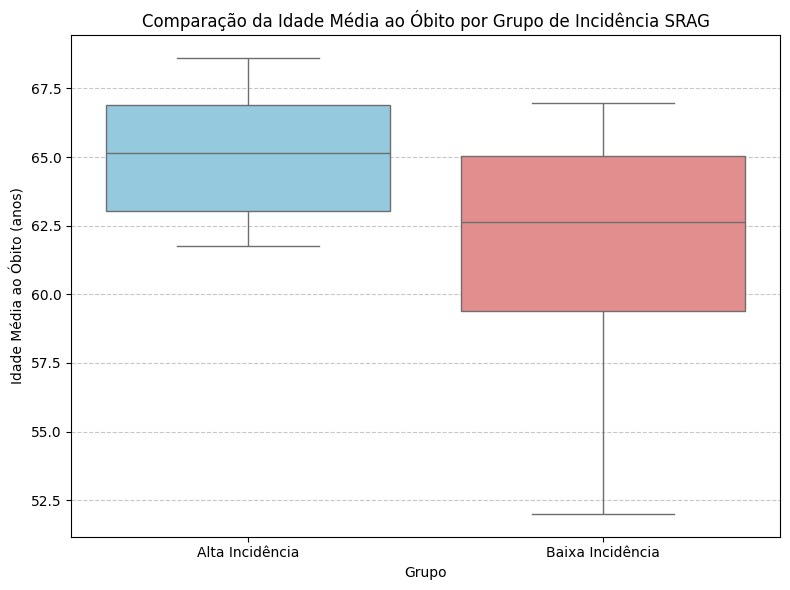

In [ ]:
# Calcular a idade média ao óbito por município/estado (SIM)

# Converte a coluna 'municipio' para string (.astype(str))
# e pega os 2 primeiros caracteres de cada linha (.str[:2])
df_sim['UF'] = df_sim['CODMUNOCOR'].astype(str).str[:2]

# Mapeia as UFs conforme seus códigos

mapa_uf = {
    '11': 'RO', '12': 'AC', '13': 'AM', '14': 'RR', '15': 'PA', '16': 'AP', '17': 'TO',
    '21': 'MA', '22': 'PI', '23': 'CE', '24': 'RN', '25': 'PB', '26': 'PE', '27': 'AL', '28': 'SE', '29': 'BA',
    '31': 'MG', '32': 'ES', '33': 'RJ', '35': 'SP',
    '41': 'PR', '42': 'SC', '43': 'RS',
    '50': 'MS', '51': 'MT', '52': 'GO', '53': 'DF'
}

df_sim['UF'] = df_sim['UF'].map(mapa_uf)




# Coluna com as idades todas em anos

# Função para calcular a idade em anos
def calcular_idade_em_anos(idade_cod):
    idade_str = str(idade_cod)
    if len(idade_str) < 2:
        # Caso idade_str inválida, retornar NaN ou outro valor padrão
        return np.nan
    # Extrai a unidade e o valor
    unidade = idade_str[0]
    valor = int(idade_str[1:])

    # Aplica as regras de conversão
    if unidade == '1': # Minutos
        # Converte minutos para anos (1 ano = 365.25 dias * 24 horas * 60 min)
        return valor / (60 * 24 * 365.25)
    elif unidade == '2': # Horas
        # Converte horas para anos
        return valor / (24 * 365.25)
    elif unidade == '3': # Meses
        # Converte meses para anos
        return valor / 12.0
    elif unidade == '4': # Anos
        return float(valor)
    elif unidade == '5': # Idade > 100 anos
        return float(100 + valor)
    elif unidade == '9': # Ignorado
        return np.nan
    else:
        return np.nan

df_sim['IDADE_ANOS'] = df_sim['IDADE'].apply(calcular_idade_em_anos)



df_sim['IDADE_ANOS'] = pd.to_numeric(df_sim['IDADE_ANOS'], errors='coerce')



# Agrupar por UF (Estado) e calcular a idade média ao óbito
media_idade_obito_por_uf = df_sim.groupby('UF')['IDADE_ANOS'].mean().reset_index()
media_idade_obito_por_uf.rename(columns={'IDADE_ANOS': 'Media_Idade_Obito'}, inplace=True)


# Calcular a taxa de internações SRAG por região (UF)
# Contar o número de internações por UF em df_srag
internacoes_srag_por_uf = df_srag['SG_UF_NOT'].value_counts().reset_index()
internacoes_srag_por_uf.rename(columns={ 'SG_UF_NOT': 'UF', 'count': 'Contagem'}, inplace=True)



# Para calcular a taxa, precisaríamos da população de cada UF.
# Como não temos os dados de população, utilizamos os dados do IBGE.

# Lista de dados com nomes, siglas e população
dados = [
    ('RO', 1815278),
    ('AC', 906876),
    ('AM', 4269995),
    ('RR', 652713),
    ('PA', 8777124),
    ('AP', 877613),
    ('TO', 1607363),
    ('MA', 7153262),
    ('PI', 3289290),
    ('CE', 9240580),
    ('RN', 3560903),
    ('PB', 4059905),
    ('PE', 9674793),
    ('AL', 3365351),
    ('SE', 2338474),
    ('BA', 14985284),
    ('MG', 21411923),
    ('ES', 4108508),
    ('RJ', 17463349),
    ('SP', 46649132),
    ('PR', 11597484),
    ('SC', 7338473),
    ('RS', 11466630),
    ('MS', 2839188),
    ('MT', 3567234),
    ('GO', 7206589),
    ('DF', 3094325)
]

# Criar DataFrame
df_populacao = pd.DataFrame(dados, columns=['UF', 'Populacao'])


# Unir os dados de internação com os de população
df_com_populacao = pd.merge(internacoes_srag_por_uf, df_populacao, on='UF')

# Calcular a taxa
df_com_populacao['Taxa_Internacao'] = (df_com_populacao['Contagem'] / df_com_populacao['Populacao']) * 100000

# Unir com os dados de idade média ao óbito
df_comparacao = pd.merge(media_idade_obito_por_uf, df_com_populacao, on='UF', how='inner')

# Separar os grupos usando a mediana da taxa
mediana_taxa_internacoes = df_comparacao['Taxa_Internacao'].median()
df_alta_incidencia = df_comparacao[df_comparacao['Taxa_Internacao'] > mediana_taxa_internacoes]
df_baixa_incidencia = df_comparacao[df_comparacao['Taxa_Internacao'] <= mediana_taxa_internacoes]




print(f"\nMediana de taxa de internações SRAG por UF: {mediana_taxa_internacoes}")
print(f"Número de UFs no grupo de alta incidência: {len(df_alta_incidencia)}")
print(f"Número de UFs no grupo de baixa incidência: {len(df_baixa_incidencia)}")






# Teste de normalidade (Shapiro-Wilk) para a idade média ao óbito em cada grupo

shapiro_alta = stats.shapiro(df_alta_incidencia['Media_Idade_Obito'])
shapiro_baixa = stats.shapiro(df_baixa_incidencia['Media_Idade_Obito'])

print(f"\nTeste Shapiro-Wilk para Idade Média ao Óbito (Alta Incidência SRAG): Estatística={shapiro_alta[0]:.4f}, p-valor={shapiro_alta[1]:.4f}")
print(f"Teste Shapiro-Wilk para Idade Média ao Óbito (Baixa Incidência SRAG): Estatística={shapiro_baixa[0]:.4f}, p-valor={shapiro_baixa[1]:.4f}")

# Teste t para comparar as médias de idade ao óbito entre os dois grupos
# Aqui, vamos assumir variâncias iguais para o teste t padrão.

# Verificando se há dados suficientes em ambos os grupos para o teste t
if len(df_alta_incidencia) < 2 or len(df_baixa_incidencia) < 2:
    print("\nNão há dados suficientes em um ou ambos os grupos para realizar o teste t.")
else:
    # Perform independent samples t-test
    t_stat, p_value = stats.ttest_ind(df_alta_incidencia['Media_Idade_Obito'],
                                       df_baixa_incidencia['Media_Idade_Obito'],
                                       equal_var=True)

    print(f"\nTeste t independente comparando a Idade Média ao Óbito entre grupos de Alta vs. Baixa Incidência SRAG:")
    print(f"Estatística t: {t_stat:.4f}")
    print(f"P-valor: {p_value:.4f}")

    # Interpretação do resultado
    alpha = 0.05
    if p_value < alpha:
        print(f"Resultado: O p-valor ({p_value:.4f}) é menor que o nível de significância ({alpha}).")
        print("Rejeitamos a hipótese nula. Há uma diferença estatisticamente significativa na idade média ao óbito entre regiões com alta e baixa incidência de internações SRAG.")
    else:
        print(f"Resultado: O p-valor ({p_value:.4f}) é maior que o nível de significância ({alpha}).")
        print("Não rejeitamos a hipótese nula. Não há evidência suficiente para afirmar uma diferença estatisticamente significativa na idade média ao óbito entre regiões com alta e baixa incidência de internações SRAG.")

    # Análise descritiva dos grupos
    print("\nEstatísticas Descritivas da Idade Média ao Óbito por Grupo:")
    print("Grupo Alta Incidência SRAG:")
    print(df_alta_incidencia['Media_Idade_Obito'].describe())
    print("\nGrupo Baixa Incidência SRAG:")
    print(df_baixa_incidencia['Media_Idade_Obito'].describe())

    print(f"Alta: {len(df_alta_incidencia)} valores, Baixa: {len(df_baixa_incidencia)} valores")



    # DataFrame para o boxplot
df_plot = pd.concat([
    pd.DataFrame({
        'Grupo': 'Alta Incidência',
        'Idade': df_alta_incidencia['Media_Idade_Obito']
    }),
    pd.DataFrame({
        'Grupo': 'Baixa Incidência',
        'Idade': df_baixa_incidencia['Media_Idade_Obito']
    })
])

plt.figure(figsize=(8, 6))
sns.boxplot(data=df_plot, x='Grupo', y='Idade', palette=['skyblue', 'lightcoral'])
plt.ylabel('Idade Média ao Óbito (anos)')
plt.title('Comparação da Idade Média ao Óbito por Grupo de Incidência SRAG')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Análise 4: Comparação das Proporções de Óbitos por Sexo entre os Sistemas SRAG e SIM para COVID-19 em 2021

Proporção de óbitos masculinos (SRAG): 0.554715938
Proporção de óbitos masculinos (SIM): 0.554650256
Proporção de óbitos femininos (SRAG): 0.445284062
Proporção de óbitos femininos (SIM): 0.445349744

Teste Qui-quadrado de independência:
Valor do Qui-quadrado: 0.0000
Graus de liberdade: 1
P-valor: 0.9964390434
Não há associação significativa entre sexo e sistema (SRAG vs SIM).


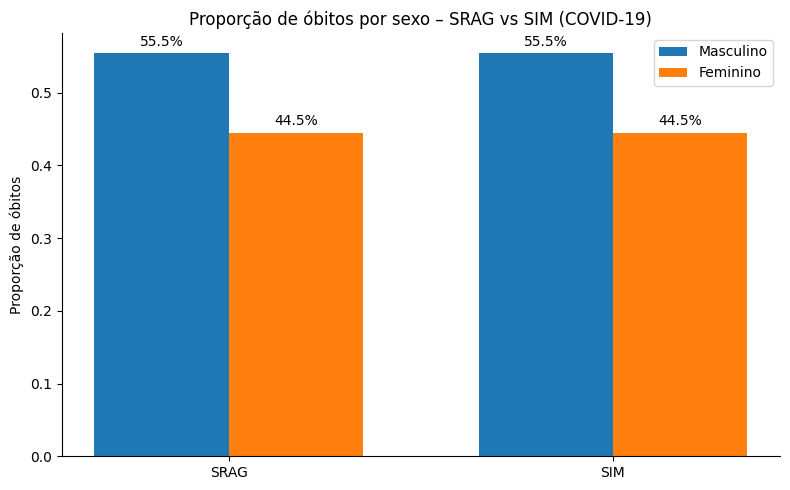

In [ ]:
# Filtrar SRAG: apenas óbitos confirmados por COVID-19
df_srag_covid_obitos = df_srag[
    (df_srag['CLASSI_FIN'] == 5) &
    (df_srag['EVOLUCAO'] == 2) &
    (df_srag['CS_SEXO'].isin(['M', 'F']))
]

# Contar por sexo no SRAG
srag_contagem_sexo = df_srag_covid_obitos['CS_SEXO'].value_counts()
total_sexo_srag = srag_contagem_sexo.sum()
prop_srag_masc = srag_contagem_sexo.get('M', 0) / total_sexo_srag
prop_srag_fem = srag_contagem_sexo.get('F', 0) / total_sexo_srag

# Filtrar SIM: apenas óbitos por COVID-19
cid_covid = ['U071', 'U072', 'B342']
df_sim_covid = df_sim[df_sim['CAUSABAS'].astype(str).str.upper().isin(cid_covid)]

# Contar por sexo no SIM
sim_contagem_sexo = df_sim_covid['SEXO'].value_counts()
total_sexo_sim = sim_contagem_sexo.get(1, 0) + sim_contagem_sexo.get(2, 0)
prop_sim_masc = sim_contagem_sexo.get(1, 0) / total_sexo_sim
prop_sim_fem = sim_contagem_sexo.get(2, 0) / total_sexo_sim

# Mostrar proporções
print(f"Proporção de óbitos masculinos (SRAG): {prop_srag_masc:.9f}")
print(f"Proporção de óbitos masculinos (SIM): {prop_sim_masc:.9f}")
print(f"Proporção de óbitos femininos (SRAG): {prop_srag_fem:.9f}")
print(f"Proporção de óbitos femininos (SIM): {prop_sim_fem:.9f}")


# Parâmetros para o teste
x1 = srag_contagem_sexo.get('M', 0)
n1 = total_sexo_srag
x2 = sim_contagem_sexo.get(1, 0)
n2 = total_sexo_sim

# Proporções
p1 = x1 / n1
p2 = x2 / n2

from scipy.stats import chi2_contingency

tabela = np.array([
    [x1, n1 - x1],  # [masculino, feminino] para SRAG
    [x2, n2 - x2]   # [masculino, feminino] para SIM
])

# Teste qui-quadrado de independência
chi2, p_chi2, dof, expected = chi2_contingency(tabela)

# Resultados
print(f"\nTeste Qui-quadrado de independência:")
print(f"Valor do Qui-quadrado: {chi2:.4f}")
print(f"Graus de liberdade: {dof}")
print(f"P-valor: {p_chi2:.10f}")

# Interpretação
alpha = 0.05
if p_chi2 < alpha:
    print("Há associação significativa entre sexo e sistema (SRAG vs SIM).")
else:
    print("Não há associação significativa entre sexo e sistema (SRAG vs SIM).")


# Gráfico de barras agrupadas: Proporção de óbitos por sexo nos sistemas SRAG e SIM

# Preparar dados para o gráfico
sistemas = ['SRAG', 'SIM']
proporcoes_masc = [prop_srag_masc, prop_sim_masc]
proporcoes_fem = [prop_srag_fem, prop_sim_fem]

x = np.arange(len(sistemas))
largura = 0.35

# Criar o gráfico
fig, ax = plt.subplots(figsize=(8, 5))
barras_masc = ax.bar(x - largura/2, proporcoes_masc, largura, label='Masculino')
barras_fem = ax.bar(x + largura/2, proporcoes_fem, largura, label='Feminino')

# Rótulos e título
ax.set_ylabel('Proporção de óbitos')
ax.set_title('Proporção de óbitos por sexo – SRAG vs SIM (COVID-19)')
ax.set_xticks(x)
ax.set_xticklabels(sistemas)
ax.legend()

# Mostrar valores percentuais nas barras
for barras in [barras_masc, barras_fem]:
    for barra in barras:
        altura = barra.get_height()
        ax.annotate(f'{altura:.1%}',
                    xy=(barra.get_x() + barra.get_width() / 2, altura),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

sns.despine()
plt.tight_layout()
plt.show()
